In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [87]:
sales = pd.read_csv("ZCity_Sales_datasetA.csv")
sales['Order_Date'] = pd.to_datetime(sales["Order_Date"])
sales

,Order_Date,Order_TotalAmount,Order_Deduct_Promocode,Order_Deduct_Zcoin,Order_Deduct_Zcoupon,Order_Deduct_Zbonus,Order_TotalSales
0,2023-12-31,98042.25,110.00,3189.38,11426.00,0.00,83316.87
1,2023-12-30,111865.35,180.00,3209.25,10444.00,0.00,98032.10
2,2023-12-29,904060.60,160.00,9535.92,10175.00,0.00,884189.68
3,2023-12-28,733777.10,270.00,8293.60,12535.49,0.00,712678.01
4,2023-12-27,563376.70,220.00,7978.66,11895.00,0.00,543283.04
...,...,...,...,...,...,...,...
1276,2020-07-03,10.00,0.00,0.00,0.00,0.00,9.86
1277,2020-07-02,23.00,0.00,0.00,0.00,0.00,22.72
1278,2020-07-01,40.00,0.00,0.00,0.00,0.00,39.86
1279,2020-06-30,11.00,0.00,0.00,0.00,0.00,10.86


In [64]:
sales['Order_Date'] = sales['Order_Date'].dt.to_period("D")
monthly_sales = sales.groupby('Order_Date').sum().reset_index()
monthly_sales['Order_Date'] = monthly_sales['Order_Date'].dt.to_timestamp()

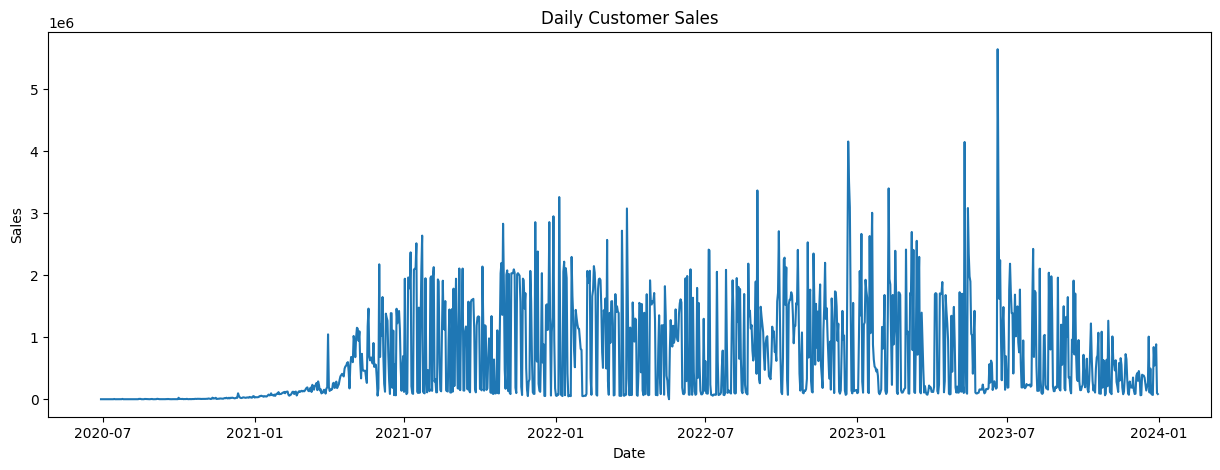

In [65]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['Order_Date'], monthly_sales['Order_TotalSales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Daily Customer Sales")
plt.show()

In [66]:
monthly_sales['sales_diff'] = monthly_sales['Order_TotalSales'].diff()
monthly_sales = monthly_sales.dropna()

In [67]:
supervised_data = monthly_sales.drop(['Order_Date', 'Order_TotalSales'], axis=1)

In [68]:
# Prepare Supervised Data
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)

In [69]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

In [70]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [71]:
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()

In [72]:
sales_dates = monthly_sales['Order_Date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
act_sales = monthly_sales['Order_TotalSales'][-13:].to_list()

Create Random Forrest Regressor Model

In [73]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pre = rf_model.predict(X_test)

rf_pre = rf_pre.reshape(-1, 1)
rf_pre_test_set = np.concatenate([rf_pre, X_test], axis=1)
rf_pre_test_set = scaler.inverse_transform(rf_pre_test_set)

In [74]:
result_list = []
for index in range(0, len(rf_pre_test_set)):
    result_list.append(rf_pre_test_set[index][0] + act_sales[index])
rf_pre_series = pd.Series(result_list, name="RandomForest Prediction")
predict_df = predict_df.merge(rf_pre_series, left_index=True, right_index=True)

In [75]:
rf_mse = np.sqrt(mean_squared_error(predict_df['RandomForest Prediction'], monthly_sales['Order_TotalSales'][-12:]))
rf_mae = mean_absolute_error(predict_df['RandomForest Prediction'], monthly_sales['Order_TotalSales'][-12:])
rf_r2 = r2_score(predict_df['RandomForest Prediction'], monthly_sales['Order_TotalSales'][-12:])
print("RandomForest MSE: ", rf_mse)
print("RandomForest MAE: ", rf_mae)
print("RandomForest R2: ", rf_r2)

RandomForest MSE:  781333.4616912822
RandomForest MAE:  664749.9404249997
RandomForest R2:  -1.2970654319417574


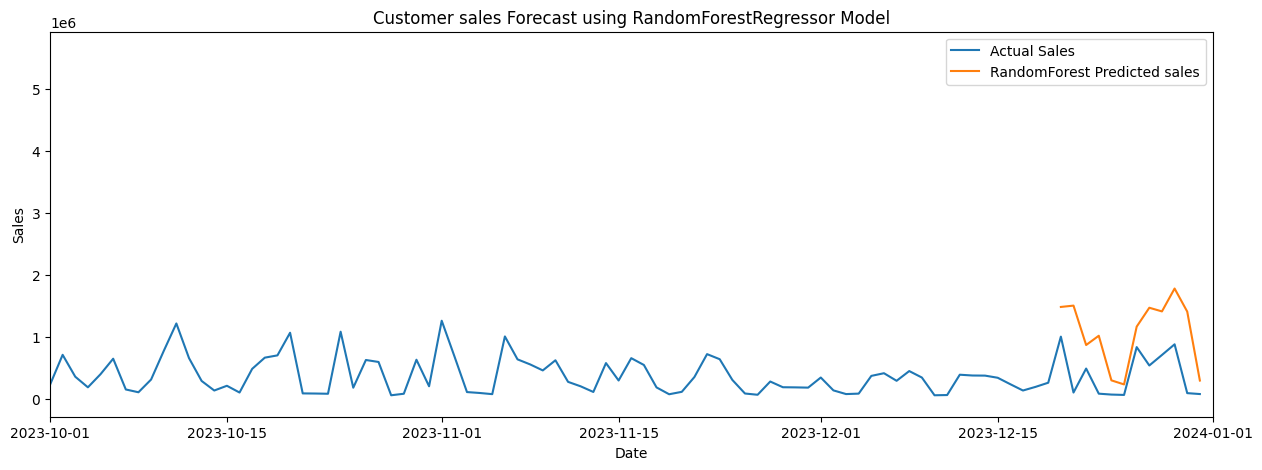

In [86]:
start_date = pd.to_datetime("2023-10-01")
end_date = pd.to_datetime("2024-01-01")

plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['Order_Date'], monthly_sales['Order_TotalSales'])
plt.plot(predict_df['Order_Date'], predict_df['RandomForest Prediction'])
plt.title("Customer sales Forecast using RandomForestRegressor Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'RandomForest Predicted sales'])

# Set x-axis limits
plt.xlim(start_date, end_date)

plt.show()


In [77]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(predict_df[['Order_Date', 'RandomForest Prediction']])

   Order_Date  RandomForest Prediction
0  2023-12-20               1485894.29
1  2023-12-21               1507457.55
2  2023-12-22                872817.72
3  2023-12-23               1022169.72
4  2023-12-24                303765.67
5  2023-12-25                238321.30
6  2023-12-26               1168976.33
7  2023-12-27               1473125.56
8  2023-12-28               1414052.08
9  2023-12-29               1782538.45
10 2023-12-30               1410899.96
11 2023-12-31                300631.08


In [85]:
# Get the number of lagged features used for training
num_lagged_features = len(supervised_data.iloc[-1, 2:].values)

# Prepare the features for predicting sales on December 20, 2024
features_for_prediction = list(supervised_data.iloc[-1, -num_lagged_features:].values)
scaled_features = scaler.transform([features_for_prediction])

# Predict the difference
predicted_diff = rf_model.predict(scaled_features)[0]

# Calculate the predicted sales
predicted_sales = monthly_sales['Order_TotalSales'].iloc[-1] + predicted_diff

print(f"Predicted sales for December 20, 2024: {predicted_sales:.2f}")


c:\Users\OngQiaoHui\vscode\Predict\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: X has 16 features, but MinMaxScaler is expecting 18 features as input.